In [17]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Read in data, check formatting compatibility
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

labels = pd.read_pickle(pickle_path / "labels.pkl")
X = pd.read_pickle(pickle_path / "X_all.pkl")
y = pd.read_pickle(pickle_path / "y_all.pkl")

if X.shape[0] != y.shape[0]: 
    # TODO: Raise Error
    print("ERROR. Dataframe shapes don't match.\n"
          "X Rows: {}"
          "y Rows: {}".format(X.shape, y.shape))

In [19]:
# Remove houses without EVs
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")
print("{} Houses without EVs".format(len(houses_woEV)))

y = y.drop(houses_woEV, errors='ignore')
X = X.drop(houses_woEV, errors='ignore')

print("Features:")
for feature in X.columns.tolist(): 
    print("  " + feature)

1105 Houses without EVs
Features:
	value
	diff
	h8_avg
	h24_avg
	h24_min
	h24_max
	h72_avg
	diff_2
	diff_3
	diff_5


In [20]:
# Scale and Split Training Data
X_train, X_test, y_train, y_test = utils.scale_split_data(X,y)

# Train logistic regression model
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train)
print("Test Score: {:.3f}".format(logreg.score(X_test, y_test)))

# Generate results for test set
results = utils.generate_test_results(X_test, y_test, logreg)

Test Score: 0.946


### Intercept and Coefficient Evaluation

In [46]:
# Evaluate Intercept
intercept = logreg.intercept_[0]
intercept_odds = np.exp(intercept)
intercept_prob = intercept_odds / (1 + intercept_odds)

print("INTERCEPT\n{:.1f}% probability of house having an EV".format(intercept_prob*100))

INTERCEPT
2.2% probability of house having an EV


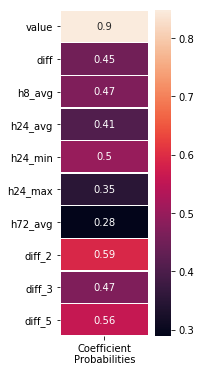

In [52]:
# Evaluate coefficients
analysis = pd.DataFrame(index=X_train.columns)
analysis['logodds'] = np.array(logreg.coef_[0])
analysis['odds'] = np.exp(analysis['logodds'])
analysis['probs'] = analysis.odds / (1 + analysis.odds)

# Display as heatmap
f, ax = plt.subplots(figsize=(2, 6))
sns.heatmap(analysis.drop(['logodds', 'odds'], axis=1), 
            annot=True, robust=True, 
            xticklabels=["Coefficient\nProbabilities"], 
            linewidths=.5
           )
f.savefig(fig_path / "b_coef_heatmap.png", 
          dpi=400,  bbox_inches='tight')

### ROC and PR

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
y_true = results['label_true']
y_scores = results['label_prob'] 
y_probs = logreg.predict_proba(X_test)[:,1]

# ROC
auc = roc_auc_score(y_true, y_scores)
print("ROC AUC Score: {:.3f}".format(auc))
fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)

# Precision-Recall (PR) Curve
ap = average_precision_score(y_true, y_scores)  
print("Average Precision Score: {:.3f}".format(ap))
p, r, thresholds_pr = precision_recall_curve(y_true, y_scores)


ROC AUC Score: 0.925
Average Precision Score: 0.624


In [51]:
# Score Summary
print("Training Score, {:.3f}".format(logreg.score(X_train, y_train)))
print("Testing Score, {:.3f}".format(logreg.score(X_test, y_test)))
print("Linear Intercept Probability, {:.3f}".format(intercept_prob))
print("ROC AUC, {:.3f}".format(auc))
print("Average Precision Score, {:.3f}".format(ap))

Training Score, 0.946
Testing Score, 0.946
Linear Intercept Probability, 0.022
ROC AUC, 0.925
Average Precision Score, 0.624


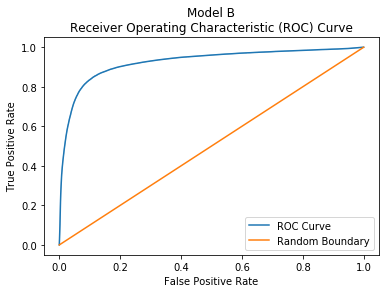

In [38]:
# Plot ROC Curve
sns.lineplot(x=fpr, y=tpr, markers='.')
sns.lineplot(x=[0,1], y=[0,1])
leg = plt.legend(('ROC Curve', 'Random Boundary'), frameon=True) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.savefig(fig_path / "b_ROC.png")
plt.show()

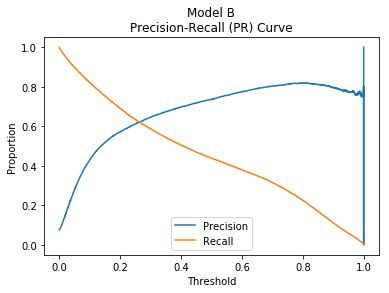

In [37]:
# Plot RP Curve
t = np.append(thresholds_pr, 1) 
if p.shape[0] != r.shape[0] != thresholds.shape[0]: 
    print("Error. Incorrect Shapes")
    print(p.shape[0], r.shape[0], t.shape[0])

sns.lineplot(t, p) 
sns.lineplot(t, r)
# sns.scatterplot(thresholds, queue_rate) 
leg = plt.legend(('Precision', 'Recall'), frameon=True) 
plt.xlabel('Threshold') 
plt.ylabel('Proportion')
plt.title('Precision-Recall (PR) Curve');

plt.savefig(fig_path / "b_PR.png")
plt.show()

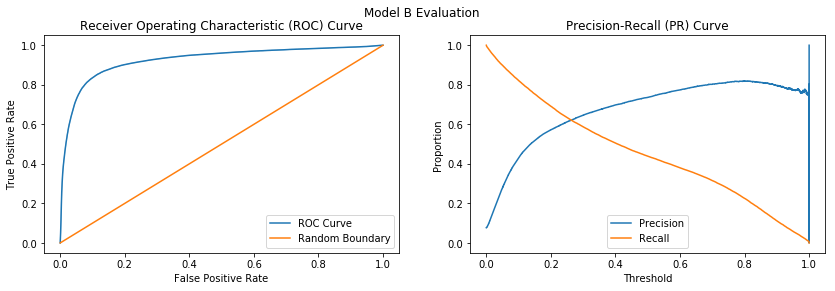

In [33]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Generate ROC Curve
sns.lineplot(x=fpr, y=tpr, markers='.', ax=axes[0])
sns.lineplot(x=[0,1], y=[0,1], ax=axes[0])
axes[0].legend(('ROC Curve', 'Random Boundary'), frameon=True) 
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')

# Generate PR Curve
sns.lineplot(t, p, ax=axes[1]) 
sns.lineplot(t, r, ax=axes[1])
axes[1].legend(('Precision', 'Recall'), frameon=True) 
axes[1].set_xlabel('Threshold') 
axes[1].set_ylabel('Proportion')
axes[1].set_title('Precision-Recall (PR) Curve');

f.suptitle('Model B Evaluation');
f.savefig(fig_path / "b_roc_pr.png", dpi=400)